In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
N = 20

start_time = time.time()

Nt = 250
Delta_x, Delta_y, Delta_z = 1/N, 1/N, 1/N
Delta_t = 1/Nt  # Time step 4.63e-5 used in paper

x_range = np.linspace(0, 1, N)
y_range = np.linspace(0, 1, N) # Doubling for half plot
z_range = np.linspace(0, 1, N)
t_range = np.linspace(0, 1, Nt) # Change for t1+t2+t3 if needed

choices_test = [
    (0.015, 0.04, 0.09),
]

layer_boundaries = [0, 1/3, 2/3, 1.0]  # Boundaries of the layers (normalized to [0,1])
u_0 = 1.0  # Initial excess pore water pressure

# Function to determine Cv based on z position
def get_cv(z):
    for i in range(len(layer_boundaries) - 1):
        if layer_boundaries[i] <= z < layer_boundaries[i + 1]:
            return cv_layers[i]
    return cv_layers[-1]  # Default to the last layer's Cv

for cv1, cv2, cv3 in choices_test:
    cv_layers = [cv1,cv2,cv3]
    
    u = np.zeros((len(x_range), len(y_range), len(z_range), len(t_range)))
    u[:, :, :, 0] = u_0

    # Start time for progress tracking
    start_time = time.time()

    # Time-stepping loop
    for n in range(0, len(t_range) - 1):
        for i in range(1, len(x_range) - 1):
            for j in range(1, len(y_range) - 1):
                for k in range(1, len(z_range) - 1):
                    cv = get_cv(z_range[k])
                    u[i, j, k, n + 1] = u[i, j, k, n] + Delta_t * (
                        cv * ((u[i + 1, j, k, n] - 2 * u[i, j, k, n] + u[i - 1, j, k, n]) / Delta_x**2 +
                              (u[i, j + 1, k, n] - 2 * u[i, j, k, n] + u[i, j - 1, k, n]) / Delta_y**2 +
                              (u[i, j, k + 1, n] - 2 * u[i, j, k, n] + u[i, j, k - 1, n]) / Delta_z**2)
                    )

        # Apply boundary conditions for the 3D Terzaghi problem (Case 2)
        u[0, :, :, n + 1] = 0  # u(0,y,z,t) = 0
        u[-1, :, :, n + 1] = 0  # u(l,y,z,t) = 0
        u[:, 0, :, n + 1] = 0  # u(x,0,z,t) = 0
        u[:, -1, :, n + 1] = 0  # u(x,b,z,t) = 0

        # Neumann boundary conditions for z direction (zero flux)
        u[:, :, 0, n + 1] = u[:, :, 1, n + 1]  # ∂u/∂z at z=0
        u[:, :, -1, n + 1] = u[:, :, -2, n + 1]  # ∂u/∂z at z=h

        # Continuity of pore pressure and flux at layer interfaces
        for k in range(1, len(z_range) - 1):
            if z_range[k] in layer_boundaries:
                cv_below = get_cv(z_range[k - 1])
                cv_above = get_cv(z_range[k + 1])
                u[:, :, k, n + 1] = (cv_below * u[:, :, k - 1, n + 1] + cv_above * u[:, :, k + 1, n + 1]) / (cv_below + cv_above)

        # Print progress every 500 time steps and write to file
        if (n + 1) % 250 == 0:
            elapsed_time = time.time() - start_time
            remaining_time = elapsed_time * (len(t_range) - n - 1) / (n + 1)
            hours, rem = divmod(remaining_time, 3600)
            minutes, seconds = divmod(rem, 60)
            progress_message = f"Time step {n + 1}/{len(t_range) - 1} completed. Estimated time remaining: {int(hours):02}:{int(minutes):02}:{int(seconds):02}"
            print(progress_message)

    print(time.time()-start_time)
            
    # Save pore pressure data to a file after completing the simulation
    # np.save(os.path.join(save_directory, f'3D_Layered_{cv1}_{cv2}_{cv3}_{N}.npy'), u)

    print("Simulation completed.")

6.333798408508301
Simulation completed.


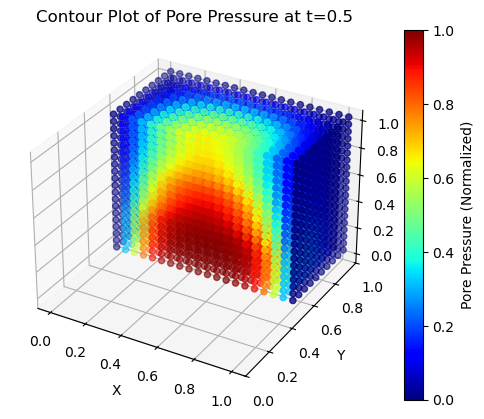

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

t_index = int(0.5*(Nt-1))

# Prepare the mesh grid for scatter plotting
X, Y, Z = np.meshgrid(x_range, y_range, z_range, indexing='ij')

# Extract the pore pressure at the specified time
u_t = u[:, :, :, t_index]

# Flatten the arrays for scatter plotting
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()
u_flat = u_t.flatten()

# Filter to include only the specified y range
mask = (Y_flat >= 0.5) & (Y_flat <= 1.0)

# Creating a 3D scatter plot
scatter = ax.scatter(X_flat[mask], Y_flat[mask], Z_flat[mask], c=u_flat[mask], cmap='jet', vmin=0, vmax=1, marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Contour Plot of Pore Pressure at t=0.5')
ax.set_ylim([0, 1])

# Adding a color bar to indicate pressure levels
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Pore Pressure (Normalized)')
plt.savefig(f'ExactSolution{N}.png', dpi=600)
plt.show()